<a href="https://colab.research.google.com/github/snowshine/NFTCreators/blob/main/gan/process_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install Image

import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [2]:
# Mount google drive to colab. need run for every session

from google.colab import drive
drive.mount('/content/drive')
# drive._mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

# change working directory
%cd /content/drive/Shareddrives/Capstone/
!ls -art

Mounted at /content/drive
/content/drive/Shareddrives/Capstone
cryptopunks.zip		   cryptopunks32.npz	mutant-ape-yacht-club128.npz
mutant-ape-yacht-club.zip  output-3-11		cryptopunks.npz
mutant-ape-yacht-club	   crytopunks_metadata	mutant-ape-yacht-club.npz
cryptopunks		   mutant_metadata


### Preparing the image dataset: convert to NumPy arrays and store for later use

load and preprocess the images. store the processed file as a binary. This way we can simply reload the processed training data and quickly use it. 

In [33]:
def prepareImages(sourcedir, outputname, result_imgshape):
  start = time.time()

  training_data = []  
  imgfiles   = np.sort(os.listdir(sourcedir))
  for filename in tqdm(imgfiles):      
      path = os.path.join(sourcedir,filename)
      image = Image.open(path).resize(result_imgshape[:2], Image.ANTIALIAS).convert('RGB')
      training_data.append(np.asarray(image))
  
  training_data = np.reshape(training_data,(-1, result_imgshape[0], result_imgshape[1], result_imgshape[2]))
  training_data = training_data.astype(np.float32)
  # Normalize the images to [-1, 1]
  training_data = training_data / 127.5 - 1.
  # rescales the image pixels to [0,1] because the RGB pixel scale for images is from 1–255
  # training_data = training_data / 255

  # Saving training image binary
  outputfile = outputname + ".npz"  # size much smaller than .npy
  np.savez_compressed(outputfile, training_data)
  
  print (f'Image preprocess time: {hms_string(time.time()-start)}')

  return outputfile

In [4]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [27]:
# result_imgshape = (32, 32, 3)
result_imgshape = (128, 128, 3)
# prepareImages('cryptopunks', 'cryptopunks', result_imgshape)
prepareImages('mutant-ape-yacht-club', 'mutant-ape-yacht-club', result_imgshape)  # 0:06:42.82

100%|██████████| 30/30 [00:00<00:00, 422.56it/s]

Image preprocess time: 0:00:00.37


'test.npz'

### Test image data
load generated image binary file, spot check data and display images

In [6]:
def plot_images(imgs, grid_size = 5):
    """
    plot images in a nxn grid
    imgs: vector containing all the numpy images
    grid_size: nxn grid containing images
    """     
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")
 
    for i in range(1, columns*rows+1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()

In [28]:
# check result
image_data = np.load('cryptopunks32.npz')['arr_0']
image_data.shape

(30, 128, 128, 3)

In [8]:
image_data = np.load('cryptopunks.npz')['arr_0']
image_data.shape

(10000, 128, 128, 3)

In [34]:
image_data = np.load('mutant-ape-yacht-club.npz')['arr_0']
image_data.shape

(10050, 128, 128, 3)

In [35]:
image_data[0][0][0][0], image_data[0][0][0][1], image_data[0][0][0][2]

(-1.0, -1.0, -1.0)

In [36]:
# scale data back to [0, 255] for display
images = (image_data + 1) * 127.5
images = images.astype(np.int32)
images[0][0][0][0], images[0][0][0][1], images[0][0][0][2]

(0, 0, 0)

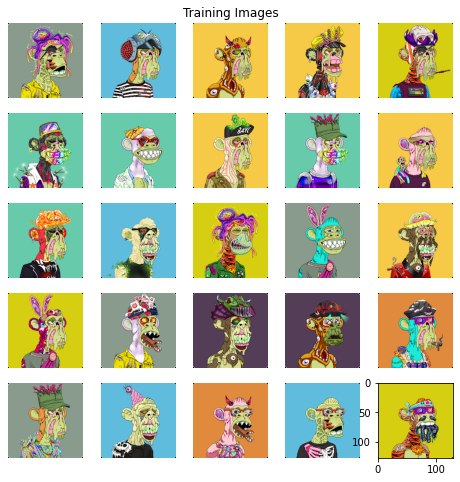

In [37]:
plot_images(images[:50])